In [3]:
### CODE 1
import requests
import pandas as pd

# API 请求参数
base_url = "https://www.ncei.noaa.gov/access/services/data/v1"
params = {
    "dataset": "daily-summaries",
    "stations": "US1CTFR0012",  # 请先查找相应地区的站点 ID
    # "datatypeid": ["TMAX", "TMIN", "TAVG", "PRCP", "RHUM", "SUNH", 'SNOW'],
    "startDate": "2000-01-01",
    "endDate": "2024-12-31",
    # "startDate": "2000-01-01",
    # "endDate": "2025-02-21",
    "format": "json"
}

# 发送请求
response = requests.get(base_url, params=params)

if response.status_code == 200:
    data = response.json()
    df1 = pd.DataFrame(data)
else:
    print("Error:", response.status_code, response.text)

In [4]:
df1

DATE      STATION   PRCP   SNOW   SNWD DAPR MDPR   WESD   WESF
0    2009-06-27  US1CTFR0012    409    NaN    NaN  NaN  NaN    NaN    NaN
1    2009-06-28  US1CTFR0012      0      0    NaN  NaN  NaN    NaN    NaN
2    2009-06-29  US1CTFR0012      0      0    NaN  NaN  NaN    NaN    NaN
3    2009-06-30  US1CTFR0012      0      0    NaN  NaN  NaN    NaN    NaN
4    2009-07-01  US1CTFR0012     43    NaN    NaN  NaN  NaN    NaN    NaN
..          ...          ...    ...    ...    ...  ...  ...    ...    ...
880  2021-09-29  US1CTFR0012    NaN      0      0  NaN  NaN      0      0
881  2021-09-30  US1CTFR0012      0      0      0  NaN  NaN      0      0
882  2021-10-04  US1CTFR0012     66    NaN    NaN  NaN  NaN    NaN    NaN
883  2021-10-05  US1CTFR0012     97      0      0  NaN  NaN      0      0
884  2021-10-27  US1CTFR0012   1204      0      0  NaN  NaN      0      0

[885 rows x 9 columns]

In [ ]:
df = pd.concat([df2, df1], ignore_index=True)
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
df = df.sort_values(by='DATE', ascending=False).reset_index(drop=True)
df = df.drop(columns='SNWD')
df['PRCP'].fillna(0, inplace=True)
df.drop(columns=['TAVG', 'STATION'], inplace=True)
# # 处理单位转换（如果数据是 1/10°C）
df["TMAX"] = df["TMAX"].apply(lambda x: int(x) / 10 if pd.notna(x) else x)
df["TMIN"] = df["TMIN"].apply(lambda x: int(x) / 10 if pd.notna(x) else x)
df["TAVG"] = df["TAVG"].apply(lambda x: int(x) / 10 if pd.notna(x) else x)

def fill_missing_tmax(df, column="TMAX", window=7):
    """
    用前后 7 天的均值填充 TMAX 缺失值，
    如果前后 7 天也有缺失值，则跳过该 NaN 值，避免错误填充。

    :param df: pandas DataFrame, 包含 DATE 和 TMAX 的数据
    :param column: 需要填充的列名（默认 "TMAX"）
    :param window: 用前后多少天的均值填充（默认 7）
    :return: 填充后的 DataFrame
    """
    df_filled = df.copy()

    # 找出 NaN 值的位置索引
    nan_indices = df_filled[df_filled[column].isna()].index

    for idx in nan_indices:
        # 确保索引在合法范围内
        start = max(idx - window, 0)
        end = min(idx + window + 1, len(df_filled))

        # 取前后 7 天的数据（不包括 NaN）
        window_values = df_filled[column].iloc[start:end].dropna().values

        # 只有在窗口内有足够的数据时才填充
        if len(window_values) > 0:
            df_filled.at[idx, column] = np.mean(window_values)

    return df_filled

# 应用缺失值填充方法
df = fill_missing_tmax(df, column="TMAX", window=7)
df = fill_missing_tmax(df, column="TMIN", window=7)

In [ ]:
df.to_csv('/content/drive/MyDrive/Projects/Cherry Blossom/CODE/Liestal-Weideli/Data/liestal_weather.csv', index=False)

In [ ]:
df

DATE      TMAX       TMIN   PRCP
0     2025-02-18  3.900000  -0.600000      0
1     2025-02-17  3.500000   0.700000      0
2     2025-02-16  4.500000  -0.700000      0
3     2025-02-15  3.900000  -2.800000      0
4     2025-02-14  6.611111   1.066667     89
...          ...       ...        ...    ...
45335 1901-01-05 -5.500000 -13.500000      0
45336 1901-01-04 -4.500000 -11.500000      0
45337 1901-01-03 -3.000000  -7.000000      0
45338 1901-01-02  0.000000  -4.000000     25
45339 1901-01-01  7.500000  -1.000000     22

[45340 rows x 4 columns]

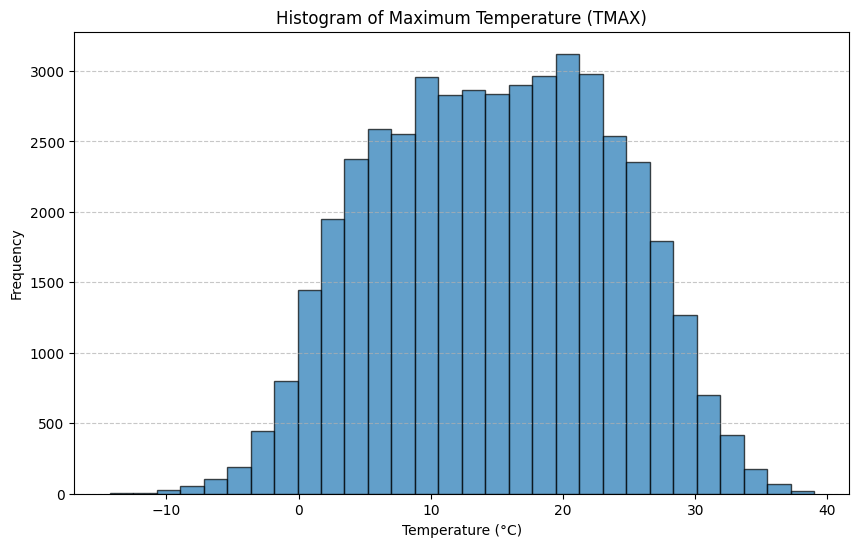

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 读取数据（假设数据已经获取并存入 DataFrame df）
# df = pd.read_csv("noaa_data.csv")  # 如果数据来自 CSV 文件

# 确保 DATE 是 datetime 格式
df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")

# 绘制温度的直方图（TMAX）
plt.figure(figsize=(10, 6))
plt.hist(df["TMAX"].dropna(), bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.title("Histogram of Maximum Temperature (TMAX)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

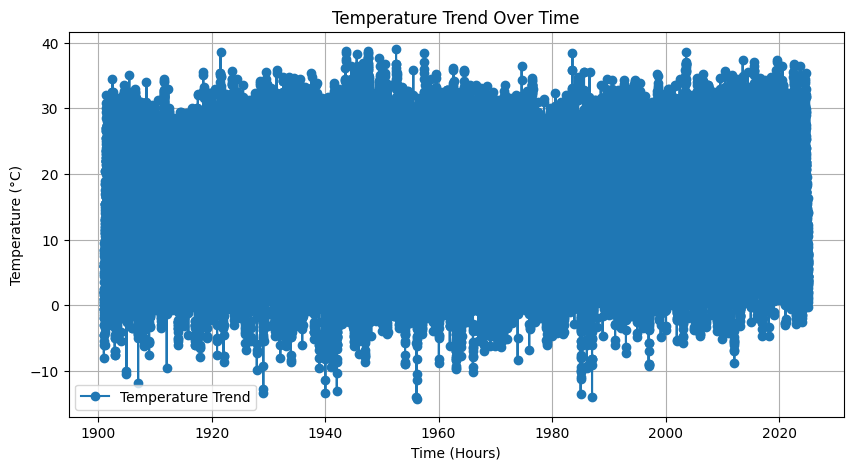

In [ ]:
df['DATE'] = pd.to_datetime(df['DATE'])
df_filtered = df.dropna(subset=['TMAX'])
# Plot temperature trend
plt.figure(figsize=(10, 5))
plt.plot(df_filtered['DATE'], df_filtered['TMAX'], marker='o', linestyle='-', label="Temperature Trend")
plt.xlabel("Time (Hours)")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Trend Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
### CODE 2
import os
from google.colab import drive

drive.mount('/content/drive')

# 填入正确路径
file_path = '/content/drive/MyDrive/Projects/Cherry Blossom/CODE/Liestal-Weideli/Data/liestal.csv'
df_cherry = pd.read_csv(file_path)
df_cherry.rename(columns={'bloom_date': 'DATE'}, inplace=True)
df_cherry["DATE"] = pd.to_datetime(df_cherry["DATE"], errors="coerce")
# final_df = df_cherry.merge(df, on='DATE', how='left')
# final_df = final_df.sort_values(by='DATE', ascending=False).reset_index(drop=True)
# final_df.dropna(inplace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_cherry.columns

Index(['location', 'lat', 'long', 'alt', 'year', 'DATE', 'bloom_doy'], dtype='object')

In [ ]:
df_cherry[['location', 'year', 'DATE', 'bloom_doy']]

location  year       DATE  bloom_doy
0    liestal  1894 1894-04-16        106
1    liestal  1895 1895-04-17        107
2    liestal  1896 1896-04-16        107
3    liestal  1897 1897-03-27         86
4    liestal  1898 1898-04-16        106
..       ...   ...        ...        ...
126  liestal  2020 2020-03-17         77
127  liestal  2021 2021-03-28         87
128  liestal  2022 2022-03-26         85
129  liestal  2023 2023-03-29         88
130  liestal  2024 2024-03-20         80

[131 rows x 4 columns]

In [ ]:
final_df.shape

(124, 10)